Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

Some Key Details
Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df1 = pd.read_csv('Melbourne_housing_FULL.csv', low_memory=False)
df1['Date'] = df1.Date.str.slice(start=-4)
df1['Date'] = pd.to_numeric(df1['Date'])
print('Dataframe dimensions:', df1.shape)
#____________________________________________________________

Dataframe dimensions: (34857, 21)


In [3]:
#df1.style.format({
#   'Lattitude': '{:,.3f}'.format,
#   'Longtitude': '{:,.3f}'.format,
#})

In [4]:
df1.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [5]:
df1.SellerG.value_counts()

Jellis                  3359
Nelson                  3236
Barry                   3235
hockingstuart           2623
Marshall                2027
Ray                     1950
Buxton                  1868
Biggin                   897
Fletchers                861
Woodards                 714
Brad                     701
McGrath                  602
Noel                     524
Greg                     519
RT                       516
Miles                    478
YPA                      473
Jas                      457
Harcourts                447
Stockdale                420
Gary                     413
Hodges                   413
Sweeney                  411
Kay                      360
Raine                    326
HAR                      309
RW                       273
Love                     269
O'Brien                  225
Village                  217
                        ... 
hockingstuart/Barry        1
Joe                        1
Fletchers/One              1
Can           

In [6]:
# gives some infos on columns types and number of null values
datainfo=pd.DataFrame(df1.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df1.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df1.isnull().sum()/df1.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
column type,object,object,int64,object,float64,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,float64
null values (nb),0,0,0,0,7610,0,0,0,1,1,8217,8226,8728,11810,21115,19306,3,7976,7976,3,3
null values (%),0,0,0,0,21.8321,0,0,0,0.00286886,0.00286886,23.5735,23.5993,25.0394,33.8813,60.5761,55.3863,0.00860659,22.8821,22.8821,0.00860659,0.00860659


In [7]:
df1.describe()


,Rooms,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34857.000000,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,2016.839946,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,0.636292,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,2016.000000,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,2016.000000,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,2017.000000,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,2017.000000,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,2018.000000,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


In [8]:
#creating integer values for catagorical variables
#Could also do this with
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(df['Col1'])
#df['Col3'] = le.transform(df['Col3'])
'''
mapping1 = {k: v for v, k in enumerate(df1.SellerG.unique())}
df1['Sellerintval'] = df1.SellerG.map(mapping1)

mapping2 = {k: v for v, k in enumerate(df1.Regionname.unique())}
df1['Regionintval'] = df1.Regionname.map(mapping2)

mapping3 = {k: v for v, k in enumerate(df1.Type.unique())}
df1['Typeintval'] = df1.Type.map(mapping3)

mapping4 = {k: v for v, k in enumerate(df1.CouncilArea.unique())}
df1['CouncilAreaintval'] = df1.CouncilArea.map(mapping4)

mapping5 = {k: v for v, k in enumerate(df1.Suburb.unique())}
df1['Suburbintval'] = df1.Suburb.map(mapping5)
'''

df1['Age'] = 2018 - df1['YearBuilt']

In [9]:
df1clean = df1.dropna().drop(['Address', 'Method',
                             'Suburb', 'Bedroom2',  'Propertycount', 'Landsize',
                              'Postcode', 'YearBuilt','SellerG',], axis=1)

Text(0.5, 1.0, 'Price vs Square Feet')

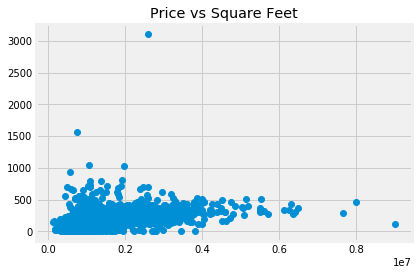

In [10]:
plt.scatter(df1clean.Price,df1clean.BuildingArea)
plt.title("Price vs Square Feet")

Text(0.5, 1.0, 'Price vs Distance')

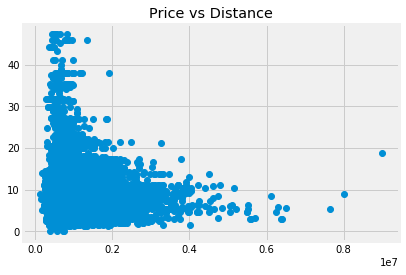

In [11]:
plt.scatter(df1clean.Price,df1clean.Distance)
plt.title("Price vs Distance")

Text(0.5, 1.0, 'Price vs Rooms')

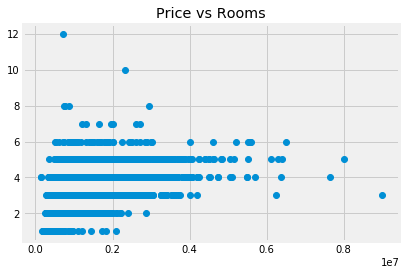

In [12]:
plt.scatter(df1clean.Price,df1clean.Rooms)
plt.title("Price vs Rooms")

In [13]:
#Log transform on price added 10 points to accuracy scores.
df1clean['Price'] = np.log(df1clean.Price)
df1clean = df1clean[(df1clean['BuildingArea']!=0)]
#Log transform on BuildingArea added 5 points to accuracy scores.
df1clean['BuildingArea'] = np.log(df1clean.BuildingArea)
#Log transform on distance made accuracy worse
#df1clean[['Distance']] = df1clean[['Distance']].replace([0], [1])
#df1clean['Distance'] = np.log(df1clean.Distance)



Text(0.5, 1.0, 'Price vs Square Feet')

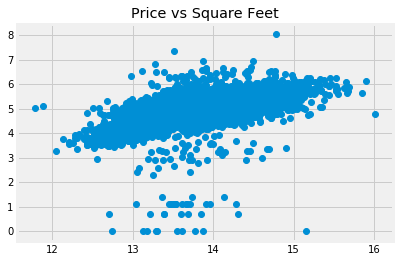

In [14]:
plt.scatter(df1clean.Price,df1clean.BuildingArea)
plt.title("Price vs Square Feet")

In [15]:
df1clean.describe()

,Rooms,Price,Date,Distance,Bathroom,Car,BuildingArea,Lattitude,Longtitude,Age
count,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000
mean,3.096811,13.753739,2016.722009,11.187412,1.645781,1.691812,4.877576,-37.804679,144.991291,52.308075
std,0.964072,0.534721,0.657730,6.810991,0.722307,0.976664,0.554975,0.090367,0.118965,37.057287
min,1.000000,11.782953,2016.000000,0.000000,1.000000,0.000000,0.000000,-38.174360,144.423790,-1.000000
25%,2.000000,13.371174,2016.000000,6.400000,1.000000,1.000000,4.605170,-37.858788,144.919700,18.000000
50%,3.000000,13.710150,2017.000000,10.200000,2.000000,2.000000,4.882802,-37.798700,144.998300,48.000000
75%,4.000000,14.111905,2017.000000,13.900000,2.000000,2.000000,5.192957,-37.749300,145.064475,73.000000
max,12.000000,16.012735,2018.000000,47.400000,9.000000,10.000000,8.043021,-37.407200,145.526350,822.000000


In [16]:
# gives some infos on columns types and number of null values
datainfo=pd.DataFrame(df1clean.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df1clean.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df1clean.isnull().sum()/df1clean.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Rooms,Type,Price,Date,Distance,Bathroom,Car,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Age
column type,int64,object,float64,int64,float64,float64,float64,float64,object,float64,float64,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0


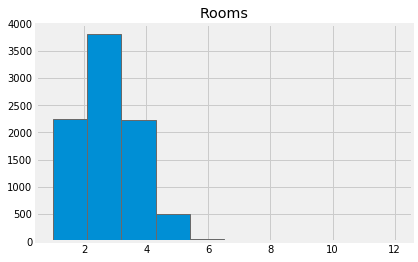

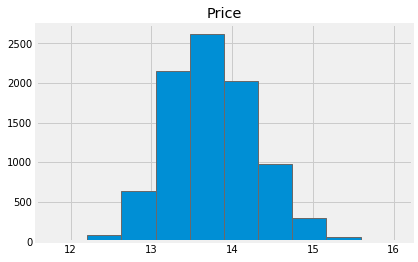

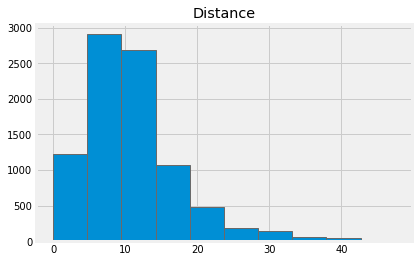

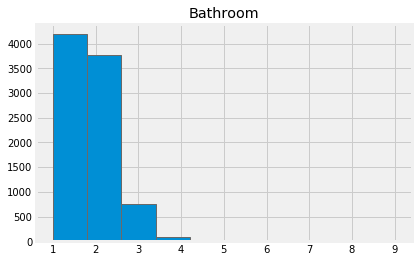

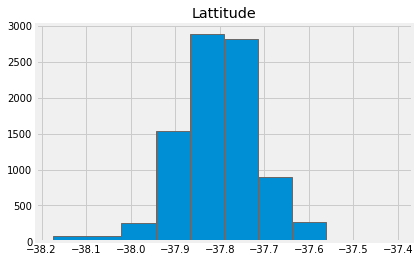

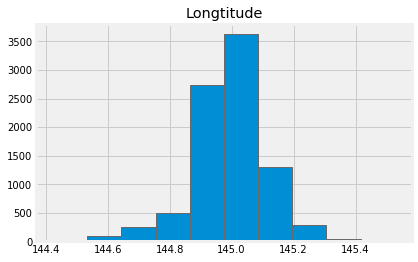

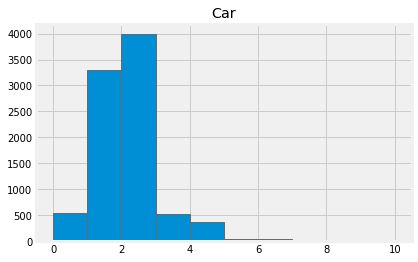

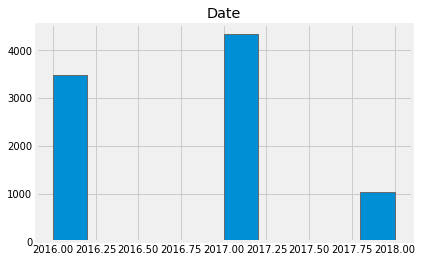

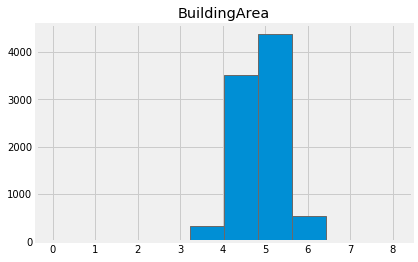

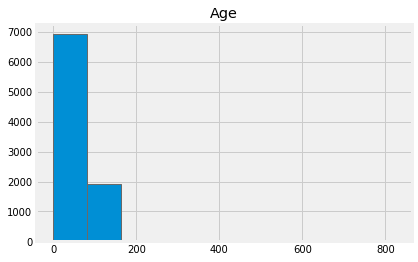

In [17]:
columnsofval1 = ['Rooms', 'Price', 'Distance', 'Bathroom', 'Lattitude', 'Longtitude',
                  'Car', 'Date','BuildingArea', 'Age']

for col in columnsofval1:
    df1clean.hist(column=[col])
    plt.show()

                 Rooms     Price      Date  Distance  Bathroom       Car  \
Rooms         1.000000  0.533980  0.188539  0.276611  0.624417  0.402286   
Price         0.533980  1.000000  0.015949 -0.237537  0.462533  0.220539   
Date          0.188539  0.015949  1.000000  0.318634  0.108645  0.152391   
Distance      0.276611 -0.237537  0.318634  1.000000  0.122682  0.259699   
Bathroom      0.624417  0.462533  0.108645  0.122682  1.000000  0.311173   
Car           0.402286  0.220539  0.152391  0.259699  0.311173  1.000000   
BuildingArea  0.670633  0.550962  0.134938  0.196952  0.552111  0.344611   
Lattitude     0.017253 -0.246214  0.048634 -0.058426 -0.042904  0.016228   
Longtitude    0.082679  0.263647  0.018476  0.164169  0.109805  0.035096   
Age          -0.005821  0.358742 -0.111880 -0.312961 -0.192682 -0.140139   

              BuildingArea  Lattitude  Longtitude       Age  
Rooms             0.670633   0.017253    0.082679 -0.005821  
Price             0.550962  -0.246214  

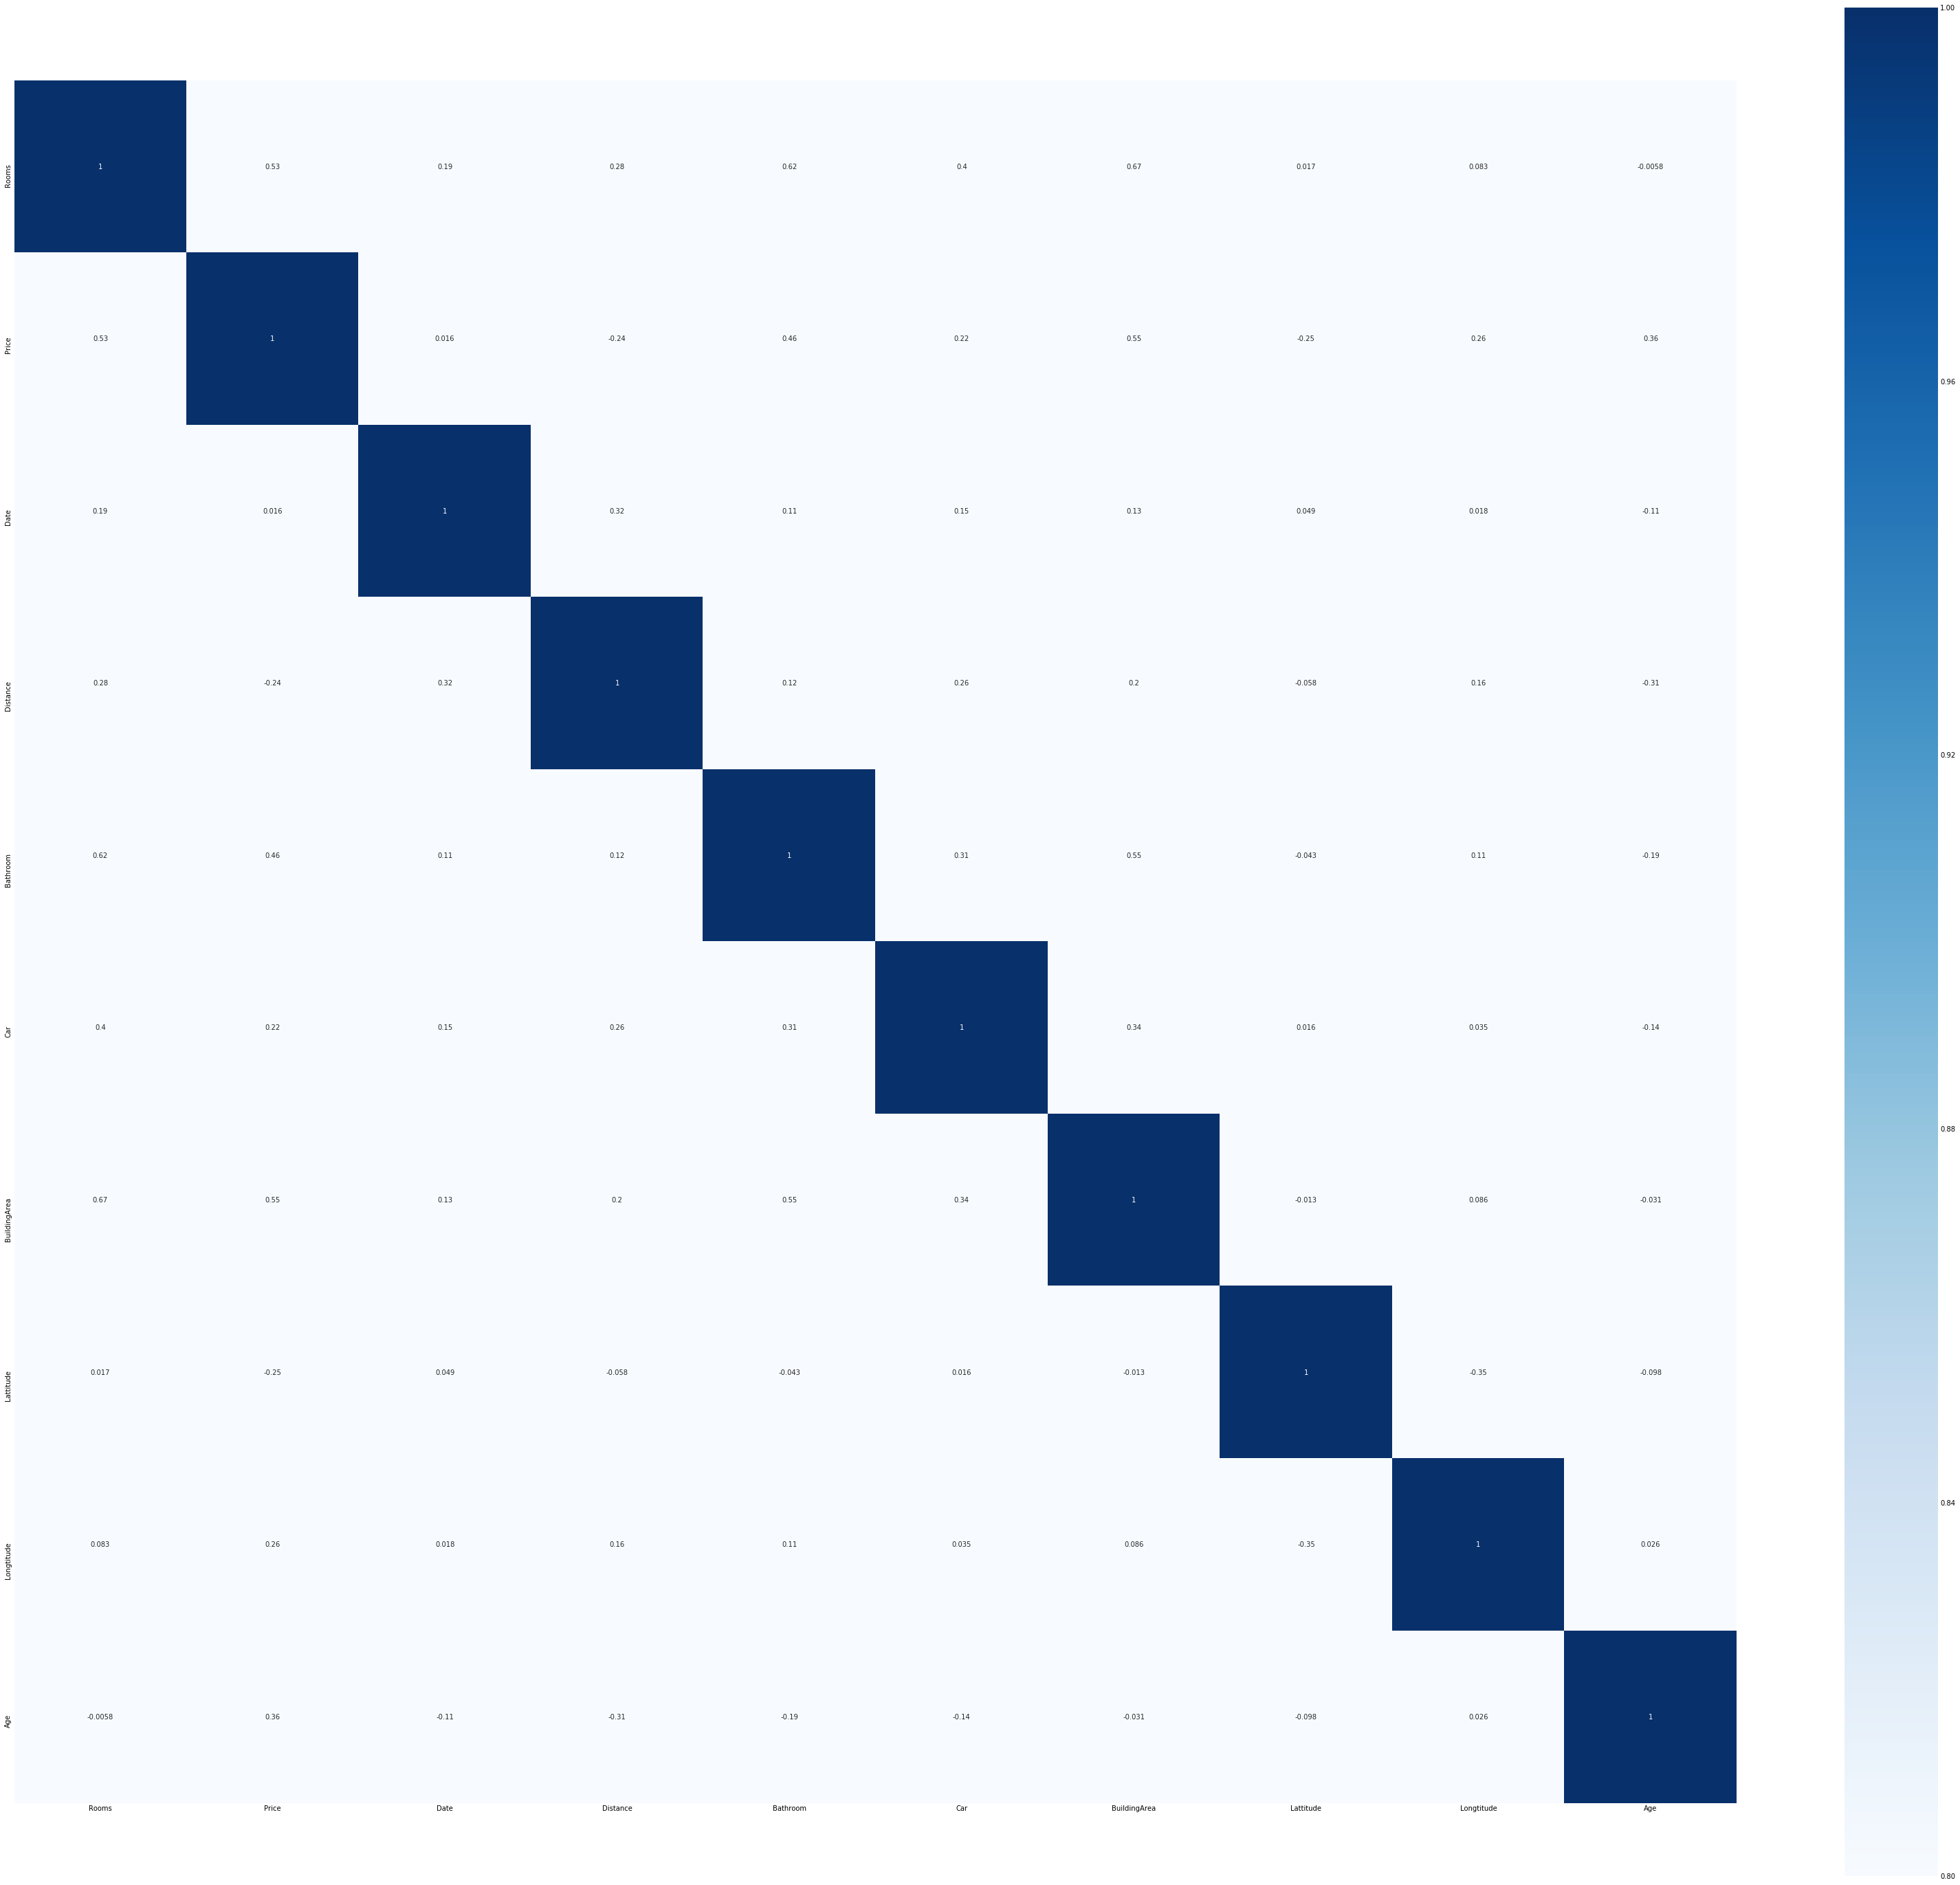

,Rooms,Price,Date,Distance,Bathroom,Car,BuildingArea,Lattitude,Longtitude,Age
Rooms,1.000000,0.533980,0.188539,0.276611,0.624417,0.402286,0.670633,0.017253,0.082679,-0.005821
Price,0.533980,1.000000,0.015949,-0.237537,0.462533,0.220539,0.550962,-0.246214,0.263647,0.358742
Date,0.188539,0.015949,1.000000,0.318634,0.108645,0.152391,0.134938,0.048634,0.018476,-0.111880
Distance,0.276611,-0.237537,0.318634,1.000000,0.122682,0.259699,0.196952,-0.058426,0.164169,-0.312961
Bathroom,0.624417,0.462533,0.108645,0.122682,1.000000,0.311173,0.552111,-0.042904,0.109805,-0.192682
Car,0.402286,0.220539,0.152391,0.259699,0.311173,1.000000,0.344611,0.016228,0.035096,-0.140139
BuildingArea,0.670633,0.550962,0.134938,0.196952,0.552111,0.344611,1.000000,-0.012616,0.085600,-0.031151
Lattitude,0.017253,-0.246214,0.048634,-0.058426,-0.042904,0.016228,-0.012616,1.000000,-0.347251,-0.097704
Longtitude,0.082679,0.263647,0.018476,0.164169,0.109805,0.035096,0.085600,-0.347251,1.000000,0.026427
Age,-0.005821,0.358742,-0.111880,-0.312961,-0.192682,-0.140139,-0.031151,-0.097704,0.026427,1.000000


In [18]:
corrmat = df1clean.corr()
print(corrmat)
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(50, 50))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.8, square=True, cmap="Blues", annot=True)
plt.show()
df1clean.corr()

In [19]:
X = pd.get_dummies(data=df1clean, columns=['Regionname', 'Type', 'CouncilArea'])
#pd.get_dummies(df1clean[['Regionname', 'Type', 'CouncilArea']])
X = X.drop(['Price'], axis=1)
y = df1clean['Price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [22]:
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [23]:
print(reg.coef_)
print(reg.intercept_)
print('Train Score :', reg.score(X_train, y_train))
print('Test Score:', reg.score(X_test, y_test))


[ 1.16449267e-01  4.11955185e-02 -2.72536462e-02  9.28576111e-02
  2.88798818e-02  1.96107260e-01 -1.18569983e+00  2.86567017e-01
  1.88221331e-03  1.21382475e-02 -1.05436220e-01 -1.33938912e-01
  1.57881823e-01 -8.80032641e-02 -4.23910529e-02  2.29888413e-02
  1.76760537e-01  2.12229171e-01  4.81166904e-02 -2.60345862e-01
 -1.34355885e-02  2.89482166e-01  2.94200569e-01 -2.94346274e-01
 -1.64230887e-01 -2.49043724e-01  7.94053227e-02 -1.41954188e-01
  6.08617750e-02 -2.18948778e-01 -1.52640591e-01 -8.28129936e-02
 -2.34300449e-02 -1.81305090e-01  7.81201641e-01  6.64077922e-02
 -2.29868419e-01 -3.95330874e-02  1.34642516e-01 -3.64220539e-01
  3.56320167e-01  4.47382878e-02 -1.00785567e-02 -3.33066907e-16
  3.39424390e-02 -1.10441392e-01  1.57451131e-01  2.61057294e-01
  8.32834134e-02 -1.44917993e-02 -5.60727650e-01  1.48946365e-01
  5.95687230e-02]
-157.10569541081549
Train Score : 0.7983486378411438
Test Score: 0.7981104447245744


In [24]:
from sklearn import metrics
print('MSE :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE : 0.057564921721967005
RMSE : 0.23992690912435605


In [25]:
reg.score(X_test,y_test)

0.7981104447245744

In [26]:
# Calculated R Squared
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))

R^2 = 0.7981341055372945


In [27]:
from sklearn import metrics
cdf = pd.DataFrame(data = reg.coef_, index = X.columns, columns = ['Coefficients'])
cdf

,Coefficients
Rooms,1.164493e-01
Date,4.119552e-02
Distance,-2.725365e-02
Bathroom,9.285761e-02
Car,2.887988e-02
BuildingArea,1.961073e-01
Lattitude,-1.185700e+00
Longtitude,2.865670e-01
Age,1.882213e-03
Regionname_Eastern Metropolitan,1.213825e-02


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

selector = RFE(reg)
selector = selector.fit(X_train, y_train)
rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,Rooms,1
23,CouncilArea_Brimbank City Council,1
24,CouncilArea_Cardinia Shire Council,1
25,CouncilArea_Casey City Council,1
51,CouncilArea_Yarra City Council,1
27,CouncilArea_Frankston City Council,1
29,CouncilArea_Greater Dandenong City Council,1
30,CouncilArea_Hobsons Bay City Council,1
31,CouncilArea_Hume City Council,1
33,CouncilArea_Knox City Council,1


# Gradient Boosting Begins here

In [29]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [30]:
df1 = pd.read_csv('Melbourne_housing_FULL.csv', low_memory=False)
df1['Date'] = df1.Date.str.slice(start=-4)
df1['Date'] = pd.to_numeric(df1['Date'])
print('Dataframe dimensions:', df1.shape)
#____________________________________________________________

Dataframe dimensions: (34857, 21)


In [31]:
#creating integer values for catagorical variables
#Could also do this with
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(df['Col1'])
#df['Col3'] = le.transform(df['Col3'])
'''
mapping1 = {k: v for v, k in enumerate(df1.SellerG.unique())}
df1['Sellerintval'] = df1.SellerG.map(mapping1)

mapping2 = {k: v for v, k in enumerate(df1.Regionname.unique())}
df1['Regionintval'] = df1.Regionname.map(mapping2)

mapping3 = {k: v for v, k in enumerate(df1.Type.unique())}
df1['Typeintval'] = df1.Type.map(mapping3)

mapping4 = {k: v for v, k in enumerate(df1.CouncilArea.unique())}
df1['CouncilAreaintval'] = df1.CouncilArea.map(mapping4)

mapping5 = {k: v for v, k in enumerate(df1.Suburb.unique())}
df1['Suburbintval'] = df1.Suburb.map(mapping5)
'''

df1['Age'] = 2018 - df1['YearBuilt']

In [32]:
df1clean = df1.dropna().drop(['Address', 'Method', 'Lattitude', 'Longtitude',
                             'Suburb', 'Bedroom2', 'SellerG', 'Propertycount', 'Landsize',
                              'Postcode', 'YearBuilt'], axis=1)

In [33]:
#Log transform on price added 10 points to accuracy scores.
df1clean['Price'] = np.log(df1clean.Price)
df1clean = df1clean[(df1clean['BuildingArea']!=0)]
#Log transform on BuildingArea added 5 points to accuracy scores.
df1clean['BuildingArea'] = np.log(df1clean.BuildingArea)
df1clean[['Distance']] = df1clean[['Distance']].replace([0], [1])
#df1clean['Distance'] = np.log(df1clean.Distance)


In [34]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [35]:
X = pd.get_dummies(data=df1clean, columns=['Regionname', 'Type', 'CouncilArea'])
#pd.get_dummies(df1clean[['Regionname', 'Type', 'CouncilArea']])
X = X.drop(['Price'], axis=1)
y = df1clean['Price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [37]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [38]:
clf.score(X_test,y_test)


0.8685381466375783

In [39]:
print('Train Score :', clf.score(X_train, y_train))
print('Test Score:', clf.score(X_test, y_test))


Train Score : 0.9486653860075799
Test Score: 0.8685381466375783


In [40]:
from sklearn import metrics
print('MSE :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE : 0.037483817763175026
RMSE : 0.19360738044603318
